# Exploratory Data Analysis - Olist E-Commerce Dataset

## Objectives
1. Understand the 9 table relationships
2. Identify data quality issues
3. Document business metrics
4. Explore key patterns and insights

## Dataset Information
- **Source**: Olist Brazilian E-Commerce Public Dataset (Kaggle)
- **Period**: September 2016 - August 2018
- **Scale**: 100K orders, 100K reviews, 9 related tables
- **Geography**: Brazilian marketplace
- **Note**: Company names in reviews anonymized with Game of Thrones house names

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
from deep_translator import GoogleTranslator

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [2]:
# Connect to DuckDB
db_path = Path('..') / 'ecommerce_raw.duckdb'
con = duckdb.connect(str(db_path))
print(f"Connected to: {db_path}")

Connected to: ..\ecommerce_raw.duckdb


## 1. Data Overview

In [3]:
# List all tables
tables = con.execute("""
    SELECT table_name, COUNT(*) as row_count
    FROM information_schema.tables
    WHERE table_schema = 'raw'
    GROUP BY table_name
    ORDER BY table_name
""").df()

# Get row counts
for table in tables['table_name']:
    count = con.execute(f"SELECT COUNT(*) FROM raw.{table}").fetchone()[0]
    tables.loc[tables['table_name'] == table, 'row_count'] = count

print("\nAvailable Tables:")
tables


Available Tables:


,table_name,row_count
0,olist_customers_dataset,99441
1,olist_geolocation_dataset,1000163
2,olist_order_items_dataset,112650
3,olist_order_payments_dataset,103886
4,olist_order_reviews_dataset,99224
5,olist_orders_dataset,99441
6,olist_products_dataset,32951
7,olist_sellers_dataset,3095
8,product_category_name_translation,71


## 2. Explore Each Table

In [4]:
# Iterate through all tables
for table_name in tables['table_name']:
    print(f"\n{'='*80}")
    print(f"Table: {table_name}")
    print('='*80)
    
    # Get sample data
    sample_data = con.execute(f"SELECT * FROM raw.{table_name} LIMIT 5").df()
    display(sample_data)
    
    # Get row count and unique key count (if applicable)
    total_rows = con.execute(f"SELECT COUNT(*) FROM raw.{table_name}").fetchone()[0]
    print(f"\nTotal Rows: {total_rows:,}")
    
    # Get column info
    columns = con.execute(f"""
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_schema = 'raw' AND table_name = '{table_name}'
        ORDER BY ordinal_position
    """).df()
    print(f"Columns: {len(columns)}")
    print(f"Column Details:\n{columns.to_string(index=False)}")


Table: olist_customers_dataset


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP



Total Rows: 99,441
Columns: 5
Column Details:
             column_name data_type
             customer_id   VARCHAR
      customer_unique_id   VARCHAR
customer_zip_code_prefix   VARCHAR
           customer_city   VARCHAR
          customer_state   VARCHAR

Table: olist_geolocation_dataset


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01037,-23.545621,-46.639292,sao paulo,SP
1,01046,-23.546081,-46.644820,sao paulo,SP
2,01046,-23.546129,-46.642951,sao paulo,SP
3,01041,-23.544392,-46.639499,sao paulo,SP
4,01035,-23.541578,-46.641607,sao paulo,SP



Total Rows: 1,000,163
Columns: 5
Column Details:
                column_name data_type
geolocation_zip_code_prefix   VARCHAR
            geolocation_lat    DOUBLE
            geolocation_lng    DOUBLE
           geolocation_city   VARCHAR
          geolocation_state   VARCHAR

Table: olist_order_items_dataset


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14



Total Rows: 112,650
Columns: 7
Column Details:
        column_name data_type
           order_id   VARCHAR
      order_item_id    BIGINT
         product_id   VARCHAR
          seller_id   VARCHAR
shipping_limit_date TIMESTAMP
              price    DOUBLE
      freight_value    DOUBLE

Table: olist_order_payments_dataset


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45



Total Rows: 103,886
Columns: 5
Column Details:
         column_name data_type
            order_id   VARCHAR
  payment_sequential    BIGINT
        payment_type   VARCHAR
payment_installments    BIGINT
       payment_value    DOUBLE

Table: olist_order_reviews_dataset


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53



Total Rows: 99,224
Columns: 7
Column Details:
            column_name data_type
              review_id   VARCHAR
               order_id   VARCHAR
           review_score    BIGINT
   review_comment_title   VARCHAR
 review_comment_message   VARCHAR
   review_creation_date TIMESTAMP
review_answer_timestamp TIMESTAMP

Table: olist_orders_dataset


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26



Total Rows: 99,441
Columns: 8
Column Details:
                  column_name data_type
                     order_id   VARCHAR
                  customer_id   VARCHAR
                 order_status   VARCHAR
     order_purchase_timestamp TIMESTAMP
            order_approved_at TIMESTAMP
 order_delivered_carrier_date TIMESTAMP
order_delivered_customer_date TIMESTAMP
order_estimated_delivery_date TIMESTAMP

Table: olist_products_dataset


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40,287,1,225,16,10,14
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44,276,1,1000,30,18,20
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46,250,1,154,18,9,15
3,cef67bcfe19066a932b7673e239eb23d,bebes,27,261,1,371,26,4,26
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37,402,4,625,20,17,13



Total Rows: 32,951
Columns: 9
Column Details:
               column_name data_type
                product_id   VARCHAR
     product_category_name   VARCHAR
       product_name_lenght    BIGINT
product_description_lenght    BIGINT
        product_photos_qty    BIGINT
          product_weight_g    BIGINT
         product_length_cm    BIGINT
         product_height_cm    BIGINT
          product_width_cm    BIGINT

Table: olist_sellers_dataset


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,04195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP



Total Rows: 3,095
Columns: 4
Column Details:
           column_name data_type
             seller_id   VARCHAR
seller_zip_code_prefix   VARCHAR
           seller_city   VARCHAR
          seller_state   VARCHAR

Table: product_category_name_translation


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor



Total Rows: 71
Columns: 2
Column Details:
                  column_name data_type
        product_category_name   VARCHAR
product_category_name_english   VARCHAR


In [5]:
# Order status distribution
status_dist = con.execute("""
    SELECT order_status, COUNT(*) as count
    FROM raw.olist_orders_dataset
    GROUP BY order_status
    ORDER BY count DESC
""").df()

print("Order Status Distribution:")
display(status_dist)

Order Status Distribution:


,order_status,count
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


In [ ]:
status_dist = con.execute("""
    SHOW SCHEMA
""").df()


ParserException: Parser Error: syntax error at or near "in"

In [10]:
# Order status distribution
status_dist = con.execute("""
    SELECT *
    FROM raw.olist_order_reviews
""").df()

CatalogException: Catalog Error: Table with name olist_order_reviews does not exist!
Did you mean "olist_order_reviews_dataset"?
LINE 3:     FROM raw.olist_order_reviews
                 ^

## 3. Data Quality Analysis

In [6]:
# 3.1 Check for duplicate records in each table
print("="*80)
print("DUPLICATE CHECK")
print("="*80)

duplicate_checks = []

# Orders - should be unique by order_id
dup_orders = con.execute("""
    SELECT COUNT(*) as total, COUNT(DISTINCT order_id) as unique_orders
    FROM raw.olist_orders_dataset
""").fetchone()
duplicate_checks.append({
    'table': 'orders',
    'total_rows': dup_orders[0],
    'unique_keys': dup_orders[1],
    'duplicates': dup_orders[0] - dup_orders[1]
})

# Customers - should be unique by customer_id
dup_customers = con.execute("""
    SELECT COUNT(*) as total, COUNT(DISTINCT customer_id) as unique_customers
    FROM raw.olist_customers_dataset
""").fetchone()
duplicate_checks.append({
    'table': 'customers',
    'total_rows': dup_customers[0],
    'unique_keys': dup_customers[1],
    'duplicates': dup_customers[0] - dup_customers[1]
})

# Products - should be unique by product_id
dup_products = con.execute("""
    SELECT COUNT(*) as total, COUNT(DISTINCT product_id) as unique_products
    FROM raw.olist_products_dataset
""").fetchone()
duplicate_checks.append({
    'table': 'products',
    'total_rows': dup_products[0],
    'unique_keys': dup_products[1],
    'duplicates': dup_products[0] - dup_products[1]
})

# Sellers - should be unique by seller_id
dup_sellers = con.execute("""
    SELECT COUNT(*) as total, COUNT(DISTINCT seller_id) as unique_sellers
    FROM raw.olist_sellers_dataset
""").fetchone()
duplicate_checks.append({
    'table': 'sellers',
    'total_rows': dup_sellers[0],
    'unique_keys': dup_sellers[1],
    'duplicates': dup_sellers[0] - dup_sellers[1]
})

# Order Items - composite key (order_id, order_item_id)
dup_order_items = con.execute("""
    SELECT 
        COUNT(*) as total,
        COUNT(DISTINCT order_id || '-' || order_item_id) as unique_items
    FROM raw.olist_order_items_dataset
""").fetchone()
duplicate_checks.append({
    'table': 'order_items',
    'total_rows': dup_order_items[0],
    'unique_keys': dup_order_items[1],
    'duplicates': dup_order_items[0] - dup_order_items[1]
})

dup_df = pd.DataFrame(duplicate_checks)
display(dup_df)

if dup_df['duplicates'].sum() > 0:
    print("\n⚠️  DUPLICATES FOUND - Investigate further")
else:
    print("\n✓ No duplicates found in primary keys")

DUPLICATE CHECK


,table,total_rows,unique_keys,duplicates
0,orders,99441,99441,0
1,customers,99441,99441,0
2,products,32951,32951,0
3,sellers,3095,3095,0
4,order_items,112650,112650,0



✓ No duplicates found in primary keys


In [7]:
# 3.2 Comprehensive NULL analysis across all tables
print("="*80)
print("NULL VALUE ANALYSIS")
print("="*80)

# Orders table
print("\n📦 ORDERS TABLE")
orders_nulls = con.execute("""
    SELECT 
        COUNT(*) as total_rows,
        SUM(CASE WHEN order_id IS NULL THEN 1 ELSE 0 END) as null_order_id,
        SUM(CASE WHEN customer_id IS NULL THEN 1 ELSE 0 END) as null_customer_id,
        SUM(CASE WHEN order_status IS NULL THEN 1 ELSE 0 END) as null_status,
        SUM(CASE WHEN order_purchase_timestamp IS NULL THEN 1 ELSE 0 END) as null_purchase_ts,
        SUM(CASE WHEN order_approved_at IS NULL THEN 1 ELSE 0 END) as null_approved_at,
        SUM(CASE WHEN order_delivered_carrier_date IS NULL THEN 1 ELSE 0 END) as null_carrier_date,
        SUM(CASE WHEN order_delivered_customer_date IS NULL THEN 1 ELSE 0 END) as null_delivered_date,
        SUM(CASE WHEN order_estimated_delivery_date IS NULL THEN 1 ELSE 0 END) as null_estimated_date
    FROM raw.olist_orders_dataset
""").df()
display(orders_nulls)

# Order Items table
print("\n📋 ORDER ITEMS TABLE")
items_nulls = con.execute("""
    SELECT 
        COUNT(*) as total_rows,
        SUM(CASE WHEN order_id IS NULL THEN 1 ELSE 0 END) as null_order_id,
        SUM(CASE WHEN product_id IS NULL THEN 1 ELSE 0 END) as null_product_id,
        SUM(CASE WHEN seller_id IS NULL THEN 1 ELSE 0 END) as null_seller_id,
        SUM(CASE WHEN price IS NULL THEN 1 ELSE 0 END) as null_price,
        SUM(CASE WHEN freight_value IS NULL THEN 1 ELSE 0 END) as null_freight
    FROM raw.olist_order_items_dataset
""").df()
display(items_nulls)

# Payments table
print("\n💳 PAYMENTS TABLE")
payments_nulls = con.execute("""
    SELECT 
        COUNT(*) as total_rows,
        SUM(CASE WHEN order_id IS NULL THEN 1 ELSE 0 END) as null_order_id,
        SUM(CASE WHEN payment_type IS NULL THEN 1 ELSE 0 END) as null_payment_type,
        SUM(CASE WHEN payment_value IS NULL THEN 1 ELSE 0 END) as null_payment_value
    FROM raw.olist_order_payments_dataset
""").df()
display(payments_nulls)

# Reviews table
print("\n⭐ REVIEWS TABLE")
reviews_nulls = con.execute("""
    SELECT 
        COUNT(*) as total_rows,
        SUM(CASE WHEN review_id IS NULL THEN 1 ELSE 0 END) as null_review_id,
        SUM(CASE WHEN order_id IS NULL THEN 1 ELSE 0 END) as null_order_id,
        SUM(CASE WHEN review_score IS NULL THEN 1 ELSE 0 END) as null_review_score,
        SUM(CASE WHEN review_comment_title IS NULL THEN 1 ELSE 0 END) as null_comment_title,
        SUM(CASE WHEN review_comment_message IS NULL THEN 1 ELSE 0 END) as null_comment_message
    FROM raw.olist_order_reviews_dataset
""").df()
display(reviews_nulls)

# Products table
print("\n🏷️  PRODUCTS TABLE")
products_nulls = con.execute("""
    SELECT 
        COUNT(*) as total_rows,
        SUM(CASE WHEN product_id IS NULL THEN 1 ELSE 0 END) as null_product_id,
        SUM(CASE WHEN product_category_name IS NULL THEN 1 ELSE 0 END) as null_category,
        SUM(CASE WHEN product_weight_g IS NULL THEN 1 ELSE 0 END) as null_weight,
        SUM(CASE WHEN product_length_cm IS NULL THEN 1 ELSE 0 END) as null_length,
        SUM(CASE WHEN product_height_cm IS NULL THEN 1 ELSE 0 END) as null_height,
        SUM(CASE WHEN product_width_cm IS NULL THEN 1 ELSE 0 END) as null_width
    FROM raw.olist_products_dataset
""").df()
display(products_nulls)

NULL VALUE ANALYSIS

📦 ORDERS TABLE


,total_rows,null_order_id,null_customer_id,null_status,null_purchase_ts,null_approved_at,null_carrier_date,null_delivered_date,null_estimated_date
0,99441,0.0,0.0,0.0,0.0,160.0,1783.0,2965.0,0.0



📋 ORDER ITEMS TABLE


,total_rows,null_order_id,null_product_id,null_seller_id,null_price,null_freight
0,112650,0.0,0.0,0.0,0.0,0.0



💳 PAYMENTS TABLE


,total_rows,null_order_id,null_payment_type,null_payment_value
0,103886,0.0,0.0,0.0



⭐ REVIEWS TABLE


,total_rows,null_review_id,null_order_id,null_review_score,null_comment_title,null_comment_message
0,99224,0.0,0.0,0.0,87656.0,58247.0



🏷️  PRODUCTS TABLE


,total_rows,null_product_id,null_category,null_weight,null_length,null_height,null_width
0,32951,0.0,610.0,2.0,2.0,2.0,2.0


In [8]:
# 3.3 Referential Integrity Checks
print("="*80)
print("REFERENTIAL INTEGRITY CHECKS")
print("="*80)

# Check for orphaned order items (order_id not in orders table)
print("\n🔗 Order Items → Orders")
orphaned_items = con.execute("""
    SELECT COUNT(*) as orphaned_items
    FROM raw.olist_order_items_dataset oi
    WHERE NOT EXISTS (
        SELECT 1 FROM raw.olist_orders_dataset o
        WHERE o.order_id = oi.order_id
    )
""").fetchone()[0]
print(f"Orphaned order items: {orphaned_items}")

# Check for orphaned payments
print("\n🔗 Order Payments → Orders")
orphaned_payments = con.execute("""
    SELECT COUNT(*) as orphaned_payments
    FROM raw.olist_order_payments_dataset p
    WHERE NOT EXISTS (
        SELECT 1 FROM raw.olist_orders_dataset o
        WHERE o.order_id = p.order_id
    )
""").fetchone()[0]
print(f"Orphaned payments: {orphaned_payments}")

# Check for orphaned reviews
print("\n🔗 Order Reviews → Orders")
orphaned_reviews = con.execute("""
    SELECT COUNT(*) as orphaned_reviews
    FROM raw.olist_order_reviews_dataset r
    WHERE NOT EXISTS (
        SELECT 1 FROM raw.olist_orders_dataset o
        WHERE o.order_id = r.order_id
    )
""").fetchone()[0]
print(f"Orphaned reviews: {orphaned_reviews}")

# Check for orders without customers
print("\n🔗 Orders → Customers")
orders_no_customer = con.execute("""
    SELECT COUNT(*) as orders_no_customer
    FROM raw.olist_orders_dataset o
    WHERE NOT EXISTS (
        SELECT 1 FROM raw.olist_customers_dataset c
        WHERE c.customer_id = o.customer_id
    )
""").fetchone()[0]
print(f"Orders without customer: {orders_no_customer}")

# Check for items with missing products
print("\n🔗 Order Items → Products")
items_no_product = con.execute("""
    SELECT COUNT(*) as items_no_product
    FROM raw.olist_order_items_dataset oi
    WHERE NOT EXISTS (
        SELECT 1 FROM raw.olist_products_dataset p
        WHERE p.product_id = oi.product_id
    )
""").fetchone()[0]
print(f"Order items without product: {items_no_product}")

# Check for items with missing sellers
print("\n🔗 Order Items → Sellers")
items_no_seller = con.execute("""
    SELECT COUNT(*) as items_no_seller
    FROM raw.olist_order_items_dataset oi
    WHERE NOT EXISTS (
        SELECT 1 FROM raw.olist_sellers_dataset s
        WHERE s.seller_id = oi.seller_id
    )
""").fetchone()[0]
print(f"Order items without seller: {items_no_seller}")

print("\n" + "="*80)
total_integrity_issues = (orphaned_items + orphaned_payments + orphaned_reviews + 
                          orders_no_customer + items_no_product + items_no_seller)
if total_integrity_issues == 0:
    print("✓ All referential integrity checks passed")
else:
    print(f"⚠️  Found {total_integrity_issues} referential integrity issues")

REFERENTIAL INTEGRITY CHECKS

🔗 Order Items → Orders
Orphaned order items: 0

🔗 Order Payments → Orders
Orphaned payments: 0

🔗 Order Reviews → Orders
Orphaned reviews: 0

🔗 Orders → Customers
Orders without customer: 0

🔗 Order Items → Products
Order items without product: 0

🔗 Order Items → Sellers
Order items without seller: 0

✓ All referential integrity checks passed


### 3.4 Date Integrity Validation

We need to check for delivered orders that have NULL approval or carrier dates, as this could signal data integrity issues.

In [9]:
# Orders table
print("\nNull Analysis for Delivered Orders in ORDERS TABLE")
orders_nulls = con.execute("""
    SELECT 
        COUNTIF(order_approved_at IS NULL) as null_order_approved_at,
        COUNTIF(order_delivered_carrier_date IS NULL) as null_order_delivered_carrier_date
    FROM 
        raw.olist_orders_dataset
    WHERE 
        order_delivered_customer_date IS NOT NULL
""").df()
display(orders_nulls)


Null Analysis for Delivered Orders in ORDERS TABLE


CatalogException: Catalog Error: Scalar Function with name countif does not exist!
Did you mean "count_if"?
LINE 3:         COUNTIF(order_approved_at ...
                ^

### 3.5 Check for Epoch Dates

Some databases use an epoch date (often 1970-01-01) in place of NULLs. Let's verify no date fields contain dates before 2015 that might indicate this pattern.

In [ ]:
# Check ALL date fields for dates before 2015
print("="*80)
print("COMPREHENSIVE DATE VALIDATION - ALL DATE FIELDS")
print("="*80)

# Orders table - all date fields
print("\n📦 ORDERS TABLE - Date Fields Before 2015:")
orders_old_dates = con.execute("""
    SELECT 
        SUM(CASE WHEN order_purchase_timestamp < '2015-01-01' THEN 1 ELSE 0 END) as purchase_before_2015,
        SUM(CASE WHEN order_approved_at < '2015-01-01' THEN 1 ELSE 0 END) as approved_before_2015,
        SUM(CASE WHEN order_delivered_carrier_date < '2015-01-01' THEN 1 ELSE 0 END) as carrier_before_2015,
        SUM(CASE WHEN order_delivered_customer_date < '2015-01-01' THEN 1 ELSE 0 END) as delivered_before_2015,
        SUM(CASE WHEN order_estimated_delivery_date < '2015-01-01' THEN 1 ELSE 0 END) as estimated_before_2015
    FROM raw.olist_orders_dataset
""").df()
display(orders_old_dates)

# If any dates before 2015 exist, show samples
if orders_old_dates.sum(axis=1)[0] > 0:
    print("\n⚠️  Sample orders with dates before 2015:")
    sample_old_orders = con.execute("""
        SELECT 
            order_id,
            order_status,
            order_purchase_timestamp,
            order_approved_at,
            order_delivered_carrier_date,
            order_delivered_customer_date,
            order_estimated_delivery_date
        FROM raw.olist_orders_dataset
        WHERE order_purchase_timestamp < '2015-01-01'
            OR order_approved_at < '2015-01-01'
            OR order_delivered_carrier_date < '2015-01-01'
            OR order_delivered_customer_date < '2015-01-01'
            OR order_estimated_delivery_date < '2015-01-01'
        LIMIT 10
    """).df()
    display(sample_old_orders)

# Reviews table - date fields
print("\n⭐ REVIEWS TABLE - Date Fields Before 2015:")
reviews_old_dates = con.execute("""
    SELECT 
        SUM(CASE WHEN review_creation_date < '2015-01-01' THEN 1 ELSE 0 END) as creation_before_2015,
        SUM(CASE WHEN review_answer_timestamp < '2015-01-01' THEN 1 ELSE 0 END) as answer_before_2015
    FROM raw.olist_order_reviews_dataset
""").df()
display(reviews_old_dates)

# If any dates before 2015 exist in reviews, show samples
if reviews_old_dates.sum(axis=1)[0] > 0:
    print("\n⚠️  Sample reviews with dates before 2015:")
    sample_old_reviews = con.execute("""
        SELECT 
            review_id,
            order_id,
            review_score,
            review_creation_date,
            review_answer_timestamp
        FROM raw.olist_order_reviews_dataset
        WHERE review_creation_date < '2015-01-01'
            OR review_answer_timestamp < '2015-01-01'
        LIMIT 10
    """).df()
    display(sample_old_reviews)

# Order Items table - shipping limit date
print("\n📋 ORDER ITEMS TABLE - Shipping Limit Date Before 2015:")
items_old_dates = con.execute("""
    SELECT 
        SUM(CASE WHEN shipping_limit_date < '2015-01-01' THEN 1 ELSE 0 END) as shipping_limit_before_2015
    FROM raw.olist_order_items_dataset
""").df()
display(items_old_dates)

if items_old_dates.sum(axis=1)[0] > 0:
    print("\n⚠️  Sample order items with shipping limit before 2015:")
    sample_old_items = con.execute("""
        SELECT 
            order_id,
            order_item_id,
            product_id,
            seller_id,
            shipping_limit_date
        FROM raw.olist_order_items_dataset
        WHERE shipping_limit_date < '2015-01-01'
        LIMIT 10
    """).df()
    display(sample_old_items)

print("\n" + "="*80)
total_old_dates = (orders_old_dates.sum(axis=1)[0] + 
                   reviews_old_dates.sum(axis=1)[0] + 
                   items_old_dates.sum(axis=1)[0])
if total_old_dates == 0:
    print("✓ No dates found before 2015 - all dates within expected range")
else:
    print(f"⚠️  Found {int(total_old_dates)} date entries before 2015")
    print("These records may need to be filtered or investigated in staging models")

COMPREHENSIVE DATE VALIDATION - ALL DATE FIELDS

📦 ORDERS TABLE - Date Fields Before 2015:


,purchase_before_2015,approved_before_2015,carrier_before_2015,delivered_before_2015,estimated_before_2015
0,0.0,0.0,0.0,0.0,0.0



⭐ REVIEWS TABLE - Date Fields Before 2015:


,creation_before_2015,answer_before_2015
0,0.0,0.0



📋 ORDER ITEMS TABLE - Shipping Limit Date Before 2015:


,shipping_limit_before_2015
0,0.0



✓ No dates found before 2015 - all dates within expected range


### 3.6 Analysis of Problematic Records

Let's examine the 14 delivered orders with null `order_approved_at` and 1 order with null `order_delivered_carrier_date` more closely.

In [ ]:
# Orders table
print("\nNull Details for Delivered Orders in ORDERS TABLE")
orders_nulls = con.execute("""
    SELECT 
        orders.order_status,
        orders.order_approved_at,
        orders.order_delivered_carrier_date,
        orders.order_delivered_customer_date,
        orders.order_estimated_delivery_date,
        customers.customer_zip_code_prefix,
        customers.customer_city,
        customers.customer_state,
        reviews.review_score,
        reviews.review_comment_title,
        reviews.review_comment_message,
        reviews.review_creation_date,
        reviews.review_answer_timestamp,
        payments.payment_type,
        payments.payment_value, 
        payments.payment_installments,
        payments.payment_sequential,
        items.price,
        items.freight_value,
        items.shipping_limit_date,
        items.order_item_id,
        products.product_category_name,
        products.product_name_lenght,
        products.product_description_lenght,
        products.product_photos_qty,
        products.product_weight_g,
        products.product_length_cm,
        products.product_height_cm,
        products.product_width_cm,
        sellers.seller_zip_code_prefix,
        sellers.seller_city,
        sellers.seller_state
    FROM 
        raw.olist_orders_dataset orders
    LEFT JOIN
        raw.olist_customers_dataset customers USING(customer_id)
    LEFT JOIN
        raw.olist_order_reviews_dataset reviews USING(order_id)
    LEFT JOIN
        raw.olist_order_payments_dataset payments USING(order_id)
    LEFT JOIN
        raw.olist_order_items_dataset items USING(order_id)
    LEFT JOIN
        raw.olist_products_dataset products USING(product_id)
    LEFT JOIN
        raw.olist_sellers_dataset sellers USING(seller_id)
    WHERE 
        order_delivered_customer_date IS NOT NULL
        AND (order_approved_at IS NULL OR order_delivered_carrier_date IS NULL)
""").df()
display(orders_nulls)


Null Details for Delivered Orders in ORDERS TABLE


,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,review_score,review_comment_title,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,delivered,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,13225,varzea paulista,SP,5,None,...,60,1738,1,300,16,15,15,03028,sao paulo,SP
1,delivered,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,27945,macae,RJ,5,None,...,54,1012,1,1200,42,25,15,03426,sao paulo,SP
2,delivered,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,36400,conselheiro lafaiete,MG,2,None,...,59,473,1,600,30,3,20,14940,ibitinga,SP
3,delivered,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29,37660,paraisopolis,MG,5,None,...,59,438,1,1200,30,5,20,14940,ibitinga,SP
4,delivered,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,03573,sao paulo,SP,5,None,...,54,586,1,1700,33,8,23,14940,ibitinga,SP
5,delivered,NaT,2017-02-22 11:31:30,2017-03-03 11:47:47,2017-03-23,95795,sao vendelino,RS,3,None,...,62,702,1,2700,42,11,36,14940,ibitinga,SP
6,delivered,NaT,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31,65110,sao jose de ribamar,MA,4,None,...,54,1012,1,1200,42,25,15,03426,sao paulo,SP
7,delivered,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,11030,santos,SP,4,None,...,33,1322,2,700,26,16,21,83323,pinhais,PR
8,delivered,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,35620,abaete,MG,5,None,...,44,441,3,4300,36,13,20,03554,sao paulo,SP
9,delivered,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,06708,cotia,SP,4,None,...,41,675,2,20800,75,40,40,14882,jaboticabal,SP


## 4. Business Metrics Exploration

In [ ]:
# Translate sample reviews from Portuguese to English
print("="*80)
print("TRANSLATING SAMPLE REVIEWS (Portuguese → English)")
print("="*80)

# Get sample reviews with comments
sample_reviews_translate = con.execute("""
    SELECT 
        review_id,
        order_id,
        review_score,
        review_comment_title,
        review_comment_message
    FROM raw.olist_order_reviews_dataset
    WHERE review_comment_message IS NOT NULL
        AND LENGTH(review_comment_message) > 20
    ORDER BY review_score, RANDOM()
    LIMIT 5
""").df()

# Initialize translator
translator = GoogleTranslator(source='pt', target='en')

print("\n🌐 Translating Reviews...\n")

for idx, row in sample_reviews_translate.iterrows():
    print("="*80)
    print(f"Review #{idx + 1} | Score: {row['review_score']}/5 ⭐")
    print("="*80)
    
    # Translate title if available
    if pd.notna(row['review_comment_title']) and row['review_comment_title'].strip():
        try:
            title_en = translator.translate(row['review_comment_title'])
            print(f"\n📌 Title (PT): {row['review_comment_title']}")
            print(f"📌 Title (EN): {title_en}")
        except Exception as e:
            print(f"⚠️  Title translation failed: {e}")
    
    # Translate message
    if pd.notna(row['review_comment_message']) and row['review_comment_message'].strip():
        try:
            # Google Translate has a 5000 character limit per request
            message_pt = row['review_comment_message'][:5000]
            message_en = translator.translate(message_pt)
            
            print(f"\n💬 Message (PT):")
            print(f"   {message_pt}")
            print(f"\n💬 Message (EN):")
            print(f"   {message_en}")
        except Exception as e:
            print(f"⚠️  Message translation failed: {e}")
    
    print("\n")

print("="*80)
print("✓ Translation complete!")
print("\nNote: Translations use Google Translate API (free tier)")

TRANSLATING SAMPLE REVIEWS (Portuguese → English)

🌐 Translating Reviews...

Review #1 | Score: 1/5 ⭐

📌 Title (PT): NAO RECOMENDO...
📌 Title (EN): I DO NOT RECOMMEND...

💬 Message (PT):
   NAO GOSTEI DO PRODUTO, E PIOR QUE A LOJA NAO DÁ OPÇAO DE TROCA NO SITE, E NO CONTATO DAS lannister NAO TEM OPÇAO PRA FALAR...

💬 Message (EN):
   I DIDN'T LIKE THE PRODUCT, AND WORSE THAT THE STORE DOESN'T GIVE AN EXCHANGE OPTION ON THE WEBSITE, AND WHEN CONTACTING Lannister THERE IS NO OPTION TO TALK ABOUT...


Review #2 | Score: 1/5 ⭐

💬 Message (PT):
   Comprei um produto no site como ELÉTRICO, paguei um valor mais alto por achar que o produto ERA ELÉTRICO. O produto chegou A PILHA e NÃO ELÉTRICO. Me senti enganada. 

💬 Message (EN):
   I bought a product on the website as ELECTRIC, I paid a higher price because I thought the product WAS ELECTRIC. The product arrived BATTERY-BASED and NOT ELECTRIC. I felt deceived.


Review #3 | Score: 1/5 ⭐

💬 Message (PT):
   paguei mais caro para receber o pro

Orders by Month:


,month,order_count
13,2017-11-01,7289
14,2017-12-01,5513
15,2018-01-01,7069
16,2018-02-01,6555
17,2018-03-01,7003
18,2018-04-01,6798
19,2018-05-01,6749
20,2018-06-01,6099
21,2018-07-01,6159
22,2018-08-01,6351


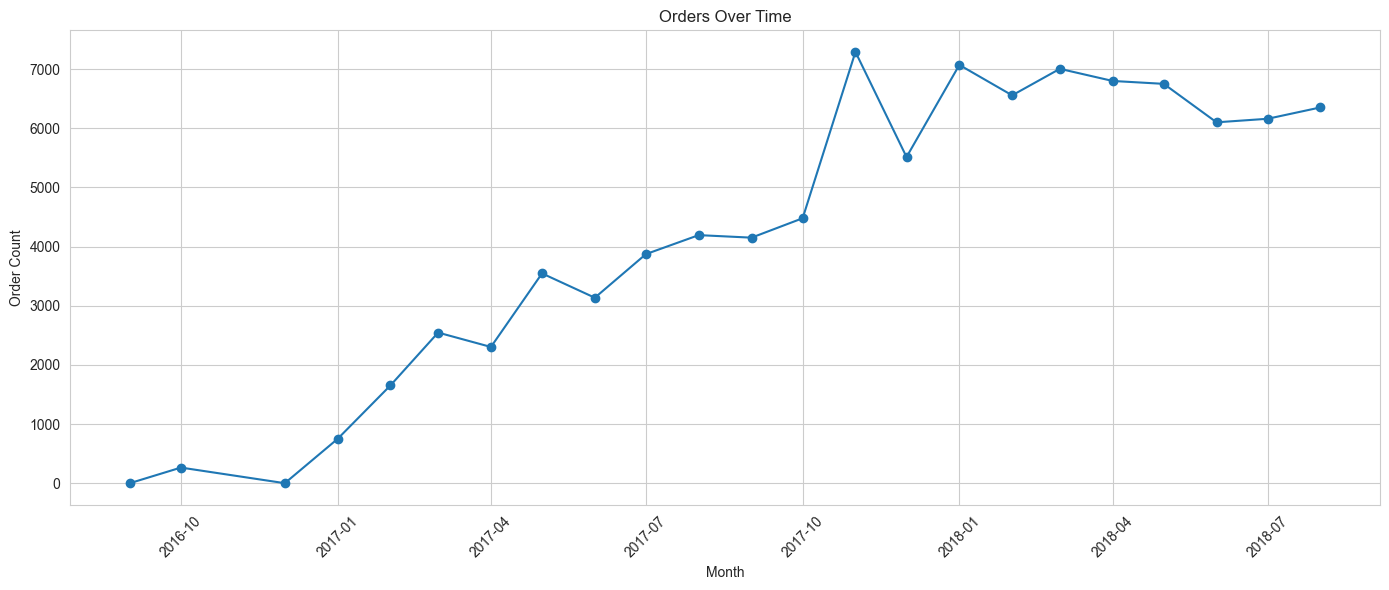

In [ ]:
# Orders over time
orders_by_month = con.execute("""
    SELECT 
        DATE_TRUNC('month', order_purchase_timestamp) as month,
        COUNT(*) as order_count
    FROM raw.olist_orders_dataset
    WHERE order_status = 'delivered'
    GROUP BY month
    ORDER BY month
""").df()

print("Orders by Month:")
display(orders_by_month.tail(10))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(orders_by_month['month'], orders_by_month['order_count'], marker='o')
plt.title('Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Order Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Order Value by Month:


,month,order_count,total_revenue,avg_order_value
13,2017-11-01,7289,1153528.05,151.919933
14,2017-12-01,5513,843199.17,147.180864
15,2018-01-01,7069,1078606.86,146.729269
16,2018-02-01,6555,966510.88,142.637379
17,2018-03-01,7003,1120678.00,153.580650
18,2018-04-01,6798,1132933.95,160.313280
19,2018-05-01,6749,1128836.69,161.216322
20,2018-06-01,6099,1012090.68,159.384359
21,2018-07-01,6159,1027903.86,161.366383
22,2018-08-01,6351,985414.28,150.790249


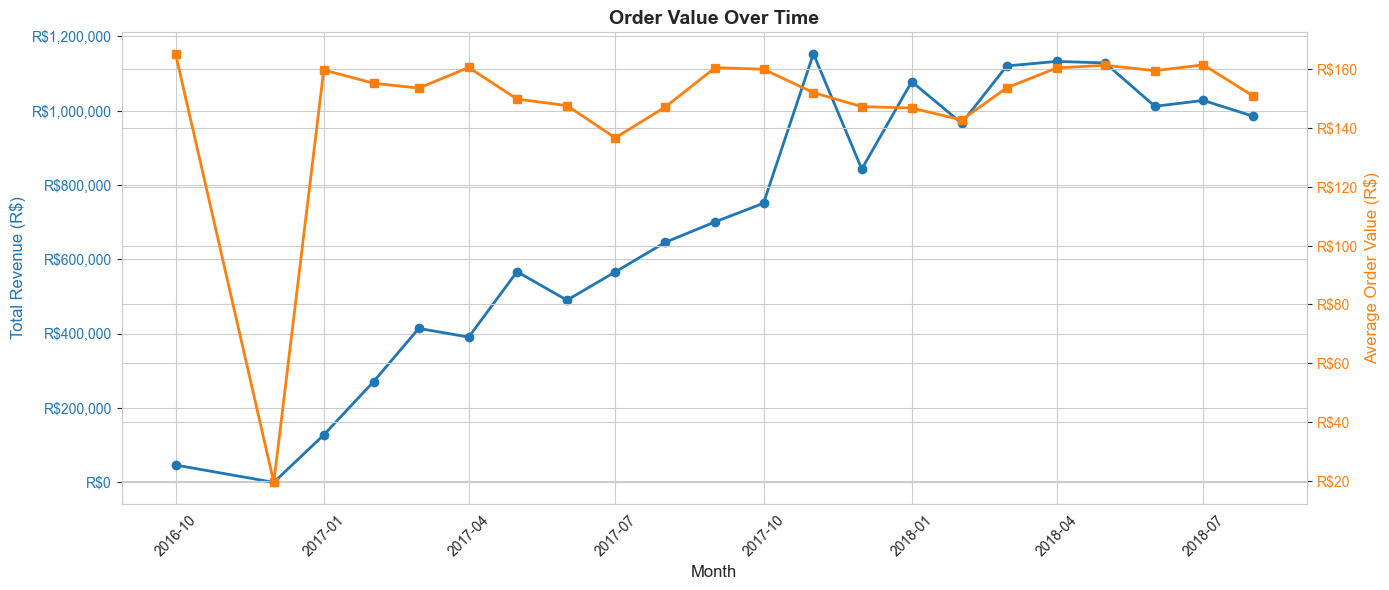

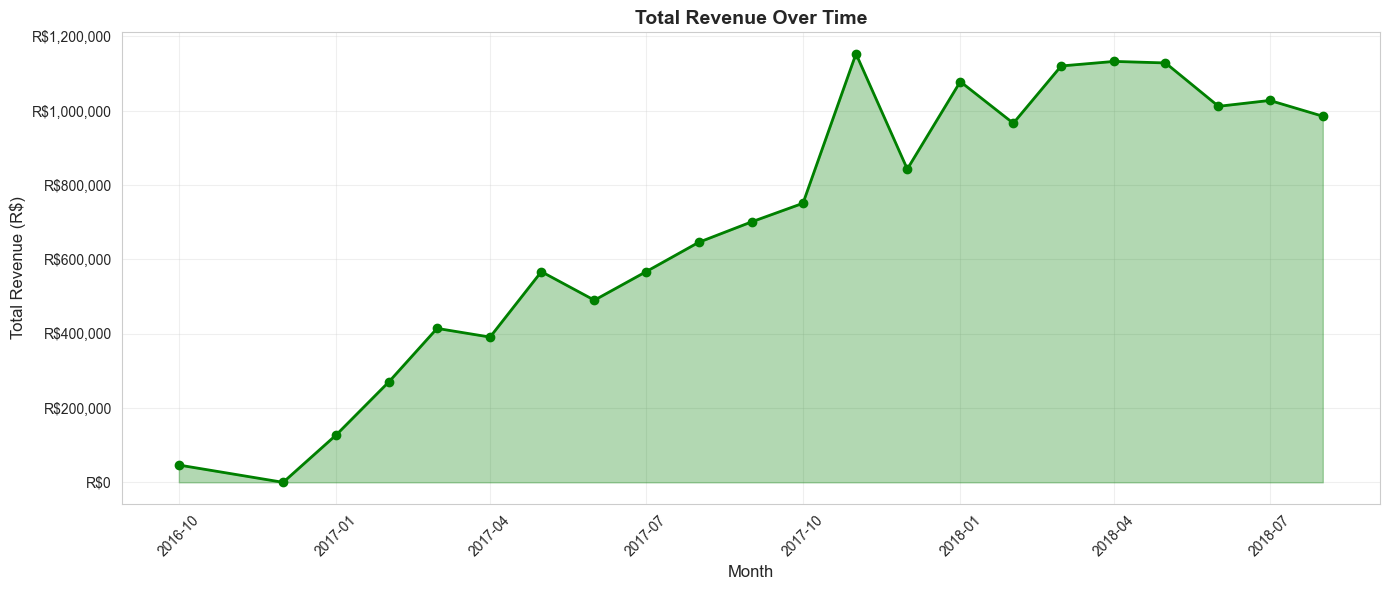

In [ ]:
# Order value over time
# Note: Dataset does not specify currency, assuming Brazilian Real (R$)
order_value_by_month = con.execute("""
    SELECT 
        DATE_TRUNC('month', o.order_purchase_timestamp) as month,
        COUNT(DISTINCT o.order_id) as order_count,
        SUM(p.payment_value) as total_revenue,
        AVG(p.payment_value) as avg_order_value
    FROM raw.olist_orders_dataset o
    LEFT JOIN raw.olist_order_payments_dataset p ON o.order_id = p.order_id
    WHERE order_status = 'delivered'
    GROUP BY month
    ORDER BY month
""").df()

print("Order Value by Month:")
display(order_value_by_month.tail(10))

# Format currency for better readability
import matplotlib.ticker as ticker

# Create subplot with dual axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot total revenue
color = 'tab:blue'
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Total Revenue (R$)', color=color, fontsize=12)
ax1.plot(order_value_by_month['month'], order_value_by_month['total_revenue'], 
         color=color, marker='o', linewidth=2, label='Total Revenue')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('R${x:,.0f}'))

# Create second y-axis for average order value
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Average Order Value (R$)', color=color, fontsize=12)
ax2.plot(order_value_by_month['month'], order_value_by_month['avg_order_value'], 
         color=color, marker='s', linewidth=2, label='Avg Order Value')
ax2.tick_params(axis='y', labelcolor=color)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('R${x:,.0f}'))

plt.title('Order Value Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

# Also create a single plot for total revenue
plt.figure(figsize=(14, 6))
plt.fill_between(order_value_by_month['month'], order_value_by_month['total_revenue'], 
                 alpha=0.3, color='green')
plt.plot(order_value_by_month['month'], order_value_by_month['total_revenue'], 
         marker='o', linewidth=2, color='green')
plt.title('Total Revenue Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue (R$)', fontsize=12)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('R${x:,.0f}'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Summary & Key Findings

### 5.1 Dataset Overview
- **9 tables** with ~1.2M total rows
- **Date range**: September 2016 - August 2018 (confirmed, no anomalies before 2015)
- **Geographic coverage**: Brazilian e-commerce marketplace
- **99,441 orders** from 99,441 customers (96,478 delivered)

In [ ]:
# Generate summary statistics for final report
print("="*80)
print("FINAL SUMMARY STATISTICS")
print("="*80)

summary_stats = con.execute("""
    SELECT 
        COUNT(DISTINCT o.order_id) as total_orders,
        COUNT(DISTINCT o.customer_id) as total_customers,
        COUNT(DISTINCT oi.product_id) as total_products,
        COUNT(DISTINCT oi.seller_id) as total_sellers,
        SUM(p.payment_value) as total_revenue,
        AVG(p.payment_value) as avg_order_value,
        AVG(oi.price) as avg_item_price,
        COUNT(DISTINCT r.review_id) as total_reviews,
        AVG(r.review_score) as avg_review_score
    FROM raw.olist_orders_dataset o
    LEFT JOIN raw.olist_order_items_dataset oi ON o.order_id = oi.order_id
    LEFT JOIN raw.olist_order_payments_dataset p ON o.order_id = p.order_id
    LEFT JOIN raw.olist_order_reviews_dataset r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
""").df()

print("\n📊 Business Metrics Summary:")
display(summary_stats)

FINAL SUMMARY STATISTICS

📊 Business Metrics Summary:


,total_orders,total_customers,total_products,total_sellers,total_revenue,avg_order_value,avg_item_price,total_reviews,avg_review_score
0,96478,96478,32216,2970,19881945.07,171.810794,119.911096,95647,4.080488


### 5.2 Data Quality Assessment

#### ✅ **Strengths**
1. **No primary key duplicates** - All entity tables have unique keys
2. **Perfect referential integrity** - All foreign keys valid (0 orphaned records)
3. **Clean date ranges** - No epoch dates
4. **No critical nulls** - IDs, keys, and core business fields complete

#### ⚠️ **Potential Issues**

1. **Null Values in Orders Table**:
   - 160 orders missing `order_approved_at` (14 with delivered status)
   - 1,783 orders missing `order_delivered_carrier_date` (1 with delivered status)
   - 2,965 orders missing `order_delivered_customer_date` (expected for non-delivered)

2. **Product Dimension Gaps**:
   - 610 products (1.9%) missing category names
   - 2 products missing physical dimensions (weight, length, height, width)
   
3. **Edge Cases**:
   - 14 delivered orders with null `order_approved_at` (business logic anomaly)
   - 1 delivered order with null `order_delivered_carrier_date` (data quality issue)

4. **Payment/Order Reconciliation**:
   - Need to validate price + freight = payment_value
   - Multiple payment methods per order (installments)

5. **Review Text in Portuguese**:
   - All review comments are in Brazilian Portuguese
   - Translation pipeline needed for NLP/sentiment analysis

### 5.3 Business Insights

1. **Revenue Growth Trend**: 
   - Observable growth in order volume and revenue from 2016-2018
   - Revenue primarily concentrated in 2017-2018

2. **Order Status Distribution** (8 distinct statuses):
   - **96,478** delivered (97.0%) - Successfully completed orders
   - **1,107** shipped (1.1%) - In transit to customer
   - **625** canceled (0.6%) - Order cancelled
   - **609** unavailable (0.6%) - Product unavailable
   - **314** invoiced (0.3%) - Invoice generated
   - **301** processing (0.3%) - Being processed
   - **5** created (0.005%) - Just created
   - **2** approved (0.002%) - Approved but not invoiced yet
   
3. **Customer Reviews**:
   - Average review score: ~4+ stars (calculated from delivered orders)
   - High review coverage (~99.8% of orders)
   - 88.3% of reviews missing titles (optional field)
   - 58.7% of reviews missing comment messages (optional field)

4. **Multi-Item Orders**:
   - Average ~1.13 items per order (112,650 items across 99,441 orders)
   - Some orders contain multiple items from different sellers
   
5. **Payment Patterns**:
   - Multiple payment methods supported (credit card, boleto, voucher, debit card)
   - Payment installments available (common in Brazilian e-commerce)
   - Some orders split across multiple payment methods

### 5.4 Recommendations for Phase 2 (dbt Transformation)

#### Staging Models (stg_*)
1. **Handle nulls** in date fields with COALESCE or appropriate defaults
2. **Translate** product category names from Portuguese to English using translation table
3. **Standardize** column names (snake_case, clear naming conventions)
4. **Cast** data types appropriately
5. **Add** row quality flags for records with missing critical data

#### Intermediate Models (int_*)
1. **Customer RFM** calculation (Recency, Frequency, Monetary)
2. **Delivery SLA** metrics (on-time vs late deliveries)
3. **Review sentiment** aggregation by product/seller
4. **Order-level** aggregations (total price, freight, payment reconciliation)
5. **Geographic enrichment** (join customers/sellers with geolocation)

#### Mart Models (fct_*, dim_*)
1. **Dimensional model** (star schema):
   - `fct_orders` - Order fact table
   - `fct_order_items` - Line item fact
   - `fct_reviews` - Review fact
   - `dim_customers` - Customer dimension
   - `dim_products` - Product dimension
   - `dim_sellers` - Seller dimension
   - `dim_date` - Date dimension
   
2. **Aggregate tables** for dashboard performance:
   - `customer_metrics` - CLV, RFM scores, purchase patterns
   - `product_metrics` - Sales, reviews, performance
   - `daily_sales` - Time-series aggregations

#### Data Quality Tests
1. **Unique** constraints on all primary keys
2. **Not null** tests on critical business fields
3. **Referential integrity** tests for all foreign keys
4. **Accepted values** tests (order_status, payment_type, review_score 1-5)
5. **Custom tests** for business rules (delivery_date >= purchase_date)

In [ ]:
# Close database connection
con.close()
print("✓ Database connection closed")

✓ Database connection closed
